Before this, you should have downloaded and unzipped all the data from kaggle.
Be sure to update your working directory to get the data all formatted.

This is directly from https://www.kaggle.com/yhn112/resnet18-baseline-pytorch-ignite/notebook

# Load the libraries

In [1]:
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
from torchvision import models

import tqdm

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm
from pathlib import Path

from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  3% |  2% |


Be sure to update path_data

In [2]:
path_data = 'D:/Deep_Learning_Final_Project/Recursion_Data_Analysis/recursion-cellular-image-classification'
batch_size = 16
torch.manual_seed(0)

# 100 Labels with Random Crop

In [3]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, mode='train', site=1, channels=[1,2,3,4,5,6], transform=None):
        self.records = df.to_records(index=False)
        self.channels = channels
        # self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.transform = transform
        self.unique_list = np.unique([int(n.split("_")[1]) for n in df['sirna']])
        self.mapping = {}
        for (i, val) in enumerate(self.unique_list):
            self.mapping[val] = i

    @staticmethod
    def _load_img_as_tensor(file_name):
        with Image.open(file_name) as img:
            return T.ToTensor()(img)

    def _get_img_path(self, index, channel, site):
        mode = self.mode
        if self.mode == 'valid':
            mode = 'train'
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,mode,experiment,f'Plate{plate}',f'{well}_s{site}_w{channel}.png'])

    def __getitem__(self, index):
        skip = False
        paths_1 = [self._get_img_path(index, ch, 1) for ch in self.channels]
        paths_2 = [self._get_img_path(index, ch, 2) for ch in self.channels]
        img_1 = []
        for img_path in paths_1:
            if Path(img_path).exists():
                # gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True)) # how to add guasian noise
                img_1.append(self._load_img_as_tensor(img_path))
            else:
                img_1.append(torch.zeros(1, 512, 512))
        img_1 = torch.cat(img_1)
        img_2 = []
        for img_path in paths_2:
            if Path(img_path).exists():
                img_2.append(self._load_img_as_tensor(img_path))
            else:
                img_2.append(torch.zeros(1, 512, 512))
        img_2 = torch.cat(img_2)
        img_1 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_1])
        img_2 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_2])
        img = torch.cat([img_1, img_2])
        if self.mode == 'train':
            # if training, then apply transformation
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split("_")[1])]
        elif self.mode == 'valid':
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split('_')[1])]
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

transforms = T.Compose([
    T.RandomCrop(384, 384),
    T.RandomHorizontalFlip(),
    T.RandomRotation(90),
    T.RandomVerticalFlip()
])

In [4]:
df = pd.read_csv(path_data+'/train.csv')
df["label"] = -1
for index, obs in df.iterrows():
    df['label'].loc[index] = int(obs['sirna'].split("_")[1])
subset_index = df['label'] <= 100
subset_df = df.loc[subset_index, :]
subset_df = subset_df.drop(['label'], axis = 1)
df_train, df_test = train_test_split(subset_df, test_size = 0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

ds_train = ImagesDS(df_train, path_data, mode='train', transform=transforms)
ds_val = ImagesDS(df_val, path_data, mode='valid')
ds_test = ImagesDS(df_test, path_data, mode='valid')

train_loader = D.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False)
valid_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=False)

C:\Users\tomj\anaconda3\envs\skorch\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Example model training

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is: {device}")

model = models.resnet18(pretrained=True)
classes = 100
model.fc = torch.nn.Linear(model.fc.in_features, classes)

trained_kernel = model.conv1.weight
new_conv = nn.Conv2d(12, 64, 7, 2, 3, bias=False)
with torch.no_grad():
    new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)] * 12, dim=1)
model.conv1 = new_conv
model = model.to(device)

Device is: cuda


In [6]:
def validation_accuracy(model, testloader, p=False):
    model.eval()
    with torch.no_grad(): # In test phase, we don't need to compute gradients (for memory efficiency)
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader, desc='Batches', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        if p:
            print(f'Accuracy of the network on the {total} test images: {(100 * correct / total)}')
        return 100 * correct / total

In [7]:
validation_accuracy(model, valid_loader, True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Accuracy of the network on the 330 test images: 1.2121212121212122


1.2121212121212122

## Learning with SGD

In [8]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [9]:
n_epochs = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in trange(n_epochs, desc='Epochs', leave=False):
    if epoch == 0:
        for name, child in model.named_children():
            if name == 'fc':
                print(f"{name} is unfrozen")
                for param in child.parameters():
                    param.requires_grad = True
            else:
                print(f"{name} is frozen")
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 10:
        print("Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True
    running_loss = 0.0
    correct = 0
    total=0
    for batch_idx, (data_, target_) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        # if (batch_idx) % 50 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #            .format(epoch + 1, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'train-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}')
  
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet_100.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6784, train-acc: 0.8608
validation loss: 4.6740, validation acc: 2.3569
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7102, train-acc: 0.8234
validation loss: 4.7601, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6998, train-acc: 1.1228
validation loss: 4.7771, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6925, train-acc: 1.3473
validation loss: 4.7609, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6826, train-acc: 1.2725
validation loss: 4.7546, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6739, train-acc: 1.4970
validation loss: 4.7512, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6659, train-acc: 1.8713
validation loss: 4.7467, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6593, train-acc: 1.7216
validation loss: 4.7419, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6537, train-acc: 1.9835
validation loss: 4.7381, validation acc: 2.3569


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6472, train-acc: 2.1707
validation loss: 4.7410, validation acc: 3.3670
Turn on all the layers


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6415, train-acc: 1.7590
validation loss: 4.7359, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6306, train-acc: 1.8713
validation loss: 4.7433, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6182, train-acc: 2.2455
validation loss: 4.7374, validation acc: 1.3468
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6054, train-acc: 2.5075
validation loss: 4.7392, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5922, train-acc: 2.7320
validation loss: 4.7325, validation acc: 2.6936
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5788, train-acc: 2.7320
validation loss: 4.7677, validation acc: 2.6936


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5654, train-acc: 2.9566
validation loss: 4.7741, validation acc: 2.3569


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5537, train-acc: 3.1063
validation loss: 4.7776, validation acc: 2.3569


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5414, train-acc: 3.7051
validation loss: 4.7722, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5299, train-acc: 3.4431
validation loss: 4.7928, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5191, train-acc: 3.4431
validation loss: 4.8210, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5079, train-acc: 4.1168
validation loss: 4.8220, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4974, train-acc: 3.7051
validation loss: 4.8255, validation acc: 4.3771


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4866, train-acc: 4.3039
validation loss: 4.8312, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4768, train-acc: 4.1916
validation loss: 4.9113, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4672, train-acc: 4.7530
validation loss: 4.9834, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4576, train-acc: 5.1272
validation loss: 4.9836, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4481, train-acc: 4.7156
validation loss: 4.9987, validation acc: 4.7138


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4385, train-acc: 5.5015
validation loss: 5.0323, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4296, train-acc: 6.1003
validation loss: 5.0702, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4205, train-acc: 5.7635
validation loss: 5.0655, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4113, train-acc: 5.9132
validation loss: 5.0580, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4015, train-acc: 6.9611
validation loss: 5.1342, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3931, train-acc: 6.1377
validation loss: 5.2128, validation acc: 1.6835


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3844, train-acc: 6.2500
validation loss: 5.2152, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3752, train-acc: 7.0359
validation loss: 5.2375, validation acc: 4.3771


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3661, train-acc: 7.4102
validation loss: 5.2446, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3568, train-acc: 8.0838
validation loss: 5.3490, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3476, train-acc: 7.7096
validation loss: 5.3836, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3381, train-acc: 8.1961
validation loss: 5.4018, validation acc: 2.6936


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3294, train-acc: 8.3458
validation loss: 5.3941, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3210, train-acc: 8.7949
validation loss: 5.4009, validation acc: 5.0505


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3119, train-acc: 8.2335
validation loss: 5.4417, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3038, train-acc: 9.7305
validation loss: 5.4874, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2943, train-acc: 9.4311
validation loss: 5.5023, validation acc: 5.3872


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2845, train-acc: 10.9281
validation loss: 5.5189, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2758, train-acc: 9.9551
validation loss: 5.5259, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2667, train-acc: 10.3293
validation loss: 5.5410, validation acc: 7.4074


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2579, train-acc: 10.7036
validation loss: 5.5723, validation acc: 2.0202


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2491, train-acc: 10.5913
validation loss: 5.5886, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2400, train-acc: 11.3772
validation loss: 5.6097, validation acc: 5.3872


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2319, train-acc: 10.8533
validation loss: 5.6168, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2233, train-acc: 10.5539
validation loss: 5.6534, validation acc: 4.7138


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2149, train-acc: 11.0778
validation loss: 5.6588, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2065, train-acc: 11.7515
validation loss: 5.6671, validation acc: 4.7138


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1979, train-acc: 11.9012
validation loss: 5.6893, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1896, train-acc: 11.8638
validation loss: 5.7146, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1816, train-acc: 11.4521
validation loss: 5.7369, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1734, train-acc: 12.3503
validation loss: 5.7433, validation acc: 6.3973


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1650, train-acc: 13.1362
validation loss: 5.8120, validation acc: 5.3872


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1570, train-acc: 13.3608
validation loss: 5.8362, validation acc: 6.0606


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1487, train-acc: 14.0719
validation loss: 5.8768, validation acc: 1.6835


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1408, train-acc: 13.5105
validation loss: 5.8685, validation acc: 8.4175


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1328, train-acc: 13.6976
validation loss: 5.8742, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1245, train-acc: 14.9326
validation loss: 5.8916, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1166, train-acc: 14.1467
validation loss: 5.9084, validation acc: 7.0707


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1089, train-acc: 14.4087
validation loss: 5.9115, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1015, train-acc: 13.9222
validation loss: 5.9333, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0943, train-acc: 13.9596
validation loss: 5.9467, validation acc: 5.7239


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0873, train-acc: 14.4835
validation loss: 5.9529, validation acc: 8.0808


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0798, train-acc: 14.8952
validation loss: 5.9708, validation acc: 8.0808


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0716, train-acc: 16.3922
validation loss: 5.9768, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0639, train-acc: 15.8683
validation loss: 6.0338, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0561, train-acc: 15.9431
validation loss: 6.0420, validation acc: 10.7744


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0484, train-acc: 16.0180
validation loss: 6.0581, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0408, train-acc: 15.4566
validation loss: 6.0658, validation acc: 9.0909


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0332, train-acc: 16.4296
validation loss: 6.0773, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0264, train-acc: 16.4296
validation loss: 6.0971, validation acc: 7.0707


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0188, train-acc: 17.6272
validation loss: 6.1098, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0110, train-acc: 17.3278
validation loss: 6.1175, validation acc: 7.0707


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0042, train-acc: 16.6168
validation loss: 6.1319, validation acc: 6.3973


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9973, train-acc: 16.1302
validation loss: 6.1392, validation acc: 10.1010


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9896, train-acc: 18.1138
validation loss: 6.1524, validation acc: 9.0909


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9821, train-acc: 18.0763
validation loss: 6.1698, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9753, train-acc: 17.5150
validation loss: 6.1882, validation acc: 9.7643


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9677, train-acc: 19.2365
validation loss: 6.2113, validation acc: 5.7239


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9601, train-acc: 18.9746
validation loss: 6.2257, validation acc: 11.1111


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9525, train-acc: 19.7979
validation loss: 6.2334, validation acc: 11.1111


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9452, train-acc: 19.4611
validation loss: 6.2445, validation acc: 9.7643


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9379, train-acc: 20.2096
validation loss: 6.2657, validation acc: 8.7542


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9309, train-acc: 19.8353
validation loss: 6.2906, validation acc: 7.7441


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9234, train-acc: 20.0225
validation loss: 6.3030, validation acc: 11.4478


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9169, train-acc: 18.9371
validation loss: 6.3173, validation acc: 8.4175


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9098, train-acc: 19.9476
validation loss: 6.3457, validation acc: 7.4074


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9027, train-acc: 20.3219
validation loss: 6.3605, validation acc: 10.1010


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8958, train-acc: 19.7231
validation loss: 6.3791, validation acc: 10.1010


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8885, train-acc: 22.1183
validation loss: 6.3939, validation acc: 10.7744


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8814, train-acc: 22.3054
validation loss: 6.4574, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8745, train-acc: 21.2201
validation loss: 6.4715, validation acc: 9.0909


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8678, train-acc: 21.1826
validation loss: 6.4874, validation acc: 8.7542


In [10]:
validation_accuracy(model, valid_loader, True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Accuracy of the network on the 330 test images: 4.848484848484849


4.848484848484849

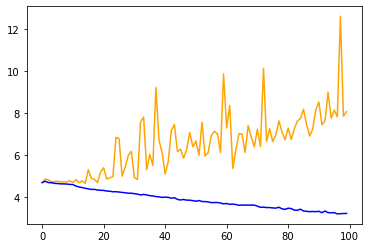

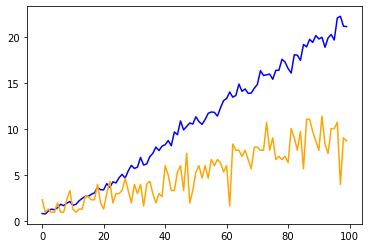

In [19]:
plt.plot(val_loss, color="orange")
plt.plot(train_loss, color="blue")
plt.show()
plt.plot(train_acc, color="blue")
plt.plot(val_acc, color="orange")
plt.show()
# train_acc
# val_acc

This is taking random crops of 384 by 384 images with both sites used. Only first 100 labels are used here.

# 100 Labels without Random Crop

In [20]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, mode='train', site=1, channels=[1,2,3,4,5,6], transform=None):
        self.records = df.to_records(index=False)
        self.channels = channels
        # self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.transform = transform
        self.unique_list = np.unique([int(n.split("_")[1]) for n in df['sirna']])
        self.mapping = {}
        for (i, val) in enumerate(self.unique_list):
            self.mapping[val] = i

    @staticmethod
    def _load_img_as_tensor(file_name):
        with Image.open(file_name) as img:
            return T.ToTensor()(img)

    def _get_img_path(self, index, channel, site):
        mode = self.mode
        if self.mode == 'valid':
            mode = 'train'
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,mode,experiment,f'Plate{plate}',f'{well}_s{site}_w{channel}.png'])

    def __getitem__(self, index):
        skip = False
        paths_1 = [self._get_img_path(index, ch, 1) for ch in self.channels]
        paths_2 = [self._get_img_path(index, ch, 2) for ch in self.channels]
        img_1 = []
        for img_path in paths_1:
            if Path(img_path).exists():
                # gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True)) # how to add guasian noise
                img_1.append(self._load_img_as_tensor(img_path))
            else:
                img_1.append(torch.zeros(1, 512, 512))
        img_1 = torch.cat(img_1)
        img_2 = []
        for img_path in paths_2:
            if Path(img_path).exists():
                img_2.append(self._load_img_as_tensor(img_path))
            else:
                img_2.append(torch.zeros(1, 512, 512))
        img_2 = torch.cat(img_2)
        img_1 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_1])
        img_2 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_2])
        img = torch.cat([img_1, img_2])
        if self.mode == 'train':
            # if training, then apply transformation
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split("_")[1])]
        elif self.mode == 'valid':
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split('_')[1])]
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

transforms = T.Compose([
    # T.RandomCrop(384, 384),
    T.RandomHorizontalFlip(),
    T.RandomRotation(90),
    T.RandomVerticalFlip()
])

In [21]:
df = pd.read_csv(path_data+'/train.csv')
df["label"] = -1
for index, obs in df.iterrows():
    df['label'].loc[index] = int(obs['sirna'].split("_")[1])
subset_index = df['label'] <= 100
subset_df = df.loc[subset_index, :]
subset_df = subset_df.drop(['label'], axis = 1)
df_train, df_test = train_test_split(subset_df, test_size = 0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

ds_train = ImagesDS(df_train, path_data, mode='train', transform=transforms)
ds_val = ImagesDS(df_val, path_data, mode='valid')
ds_test = ImagesDS(df_test, path_data, mode='valid')

train_loader = D.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False)
valid_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=False)

## Example model training

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is: {device}")

model = models.resnet18(pretrained=True)
classes = 100
model.fc = torch.nn.Linear(model.fc.in_features, classes)

trained_kernel = model.conv1.weight
new_conv = nn.Conv2d(12, 64, 7, 2, 3, bias=False)
with torch.no_grad():
    new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)] * 12, dim=1)
model.conv1 = new_conv
model = model.to(device)

Device is: cuda


## Learning with SGD

In [23]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [24]:
n_epochs = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in trange(n_epochs, desc='Epochs', leave=False):
    if epoch == 0:
        for name, child in model.named_children():
            if name == 'fc':
                print(f"{name} is unfrozen")
                for param in child.parameters():
                    param.requires_grad = True
            else:
                print(f"{name} is frozen")
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 10:
        print("Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True
    running_loss = 0.0
    correct = 0
    total=0
    for batch_idx, (data_, target_) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        # if (batch_idx) % 50 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #            .format(epoch + 1, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'train-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}')
  
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet_100_no_crop.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7134, train-acc: 1.2350
validation loss: 4.7164, validation acc: 1.0101
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6544, train-acc: 1.4970
validation loss: 4.6982, validation acc: 1.6835
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6109, train-acc: 3.4431
validation loss: 4.6961, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5759, train-acc: 3.4805
validation loss: 4.6823, validation acc: 1.6835
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5429, train-acc: 4.4162
validation loss: 4.6815, validation acc: 3.0303


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.5114, train-acc: 5.0150
validation loss: 4.6738, validation acc: 3.0303
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4847, train-acc: 5.5015
validation loss: 4.6687, validation acc: 4.7138


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4582, train-acc: 6.5494
validation loss: 4.6708, validation acc: 5.7239


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4348, train-acc: 7.1108
validation loss: 4.6716, validation acc: 4.0404


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.4120, train-acc: 7.0359
validation loss: 4.6721, validation acc: 3.3670
Turn on all the layers


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3825, train-acc: 7.5973
validation loss: 4.8015, validation acc: 3.7037


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.3269, train-acc: 12.0883
validation loss: 4.9131, validation acc: 6.7340


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.2582, train-acc: 17.7395
validation loss: 4.9852, validation acc: 7.0707


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1831, train-acc: 22.0060
validation loss: 5.0164, validation acc: 10.4377


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.1034, train-acc: 26.8338
validation loss: 5.0659, validation acc: 9.0909


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.0244, train-acc: 28.8548
validation loss: 5.1081, validation acc: 10.4377


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.9452, train-acc: 32.7470
validation loss: 5.1826, validation acc: 3.3670


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.8666, train-acc: 36.6766
validation loss: 5.2395, validation acc: 11.1111


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.7899, train-acc: 38.3234
validation loss: 5.2645, validation acc: 11.7845


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.7175, train-acc: 40.1946
validation loss: 5.3166, validation acc: 10.4377


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.6446, train-acc: 44.2740
validation loss: 5.3605, validation acc: 8.0808


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.5721, train-acc: 48.5778
validation loss: 5.4146, validation acc: 13.8047


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.5025, train-acc: 48.8772
validation loss: 5.4433, validation acc: 12.1212


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.4357, train-acc: 50.8234
validation loss: 5.4780, validation acc: 14.1414


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.3697, train-acc: 53.0314
validation loss: 5.5655, validation acc: 10.4377


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.3047, train-acc: 56.2126
validation loss: 5.5876, validation acc: 14.4781


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.2412, train-acc: 58.8698
validation loss: 5.6107, validation acc: 14.8148


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.1816, train-acc: 58.9072
validation loss: 5.6552, validation acc: 13.8047


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.1216, train-acc: 62.5749
validation loss: 5.6796, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.0627, train-acc: 65.3069
validation loss: 5.7318, validation acc: 12.7946


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 3.0041, train-acc: 68.4880
validation loss: 5.7547, validation acc: 18.5185


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.9468, train-acc: 70.2096
validation loss: 5.7908, validation acc: 12.7946


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.8907, train-acc: 72.1557
validation loss: 5.8124, validation acc: 15.8249


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.8364, train-acc: 72.5299
validation loss: 5.8315, validation acc: 19.5286


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.7827, train-acc: 76.2350
validation loss: 5.8595, validation acc: 16.8350


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.7309, train-acc: 77.0958
validation loss: 5.8932, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.6790, train-acc: 80.2769
validation loss: 5.9214, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.6270, train-acc: 83.3084
validation loss: 5.9384, validation acc: 18.1818


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.5774, train-acc: 82.3728
validation loss: 5.9687, validation acc: 15.4882


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.5293, train-acc: 84.2066
validation loss: 5.9949, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.4824, train-acc: 85.1422
validation loss: 6.0255, validation acc: 17.1717


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.4366, train-acc: 86.6766
validation loss: 6.0609, validation acc: 15.8249


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.3916, train-acc: 88.1737
validation loss: 6.0881, validation acc: 16.8350


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.3474, train-acc: 90.0075
validation loss: 6.1224, validation acc: 15.4882


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.3051, train-acc: 89.8952
validation loss: 6.1549, validation acc: 21.2121


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.2642, train-acc: 90.1572
validation loss: 6.1938, validation acc: 15.4882


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.2248, train-acc: 90.3817
validation loss: 6.2359, validation acc: 14.8148


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.1864, train-acc: 90.9057
validation loss: 6.2689, validation acc: 14.8148


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.1482, train-acc: 93.4506
validation loss: 6.2985, validation acc: 20.8754


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.1114, train-acc: 93.1886
validation loss: 6.3592, validation acc: 11.7845


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.0754, train-acc: 93.4132
validation loss: 6.3951, validation acc: 14.4781


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.0412, train-acc: 93.1138
validation loss: 6.4242, validation acc: 17.8451


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 2.0064, train-acc: 96.1452
validation loss: 6.4449, validation acc: 18.5185


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.9728, train-acc: 96.1452
validation loss: 6.4693, validation acc: 17.5084


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.9405, train-acc: 96.4072
validation loss: 6.5237, validation acc: 11.4478


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.9101, train-acc: 94.4237
validation loss: 6.5581, validation acc: 17.1717


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.8807, train-acc: 94.4985
validation loss: 6.5872, validation acc: 19.5286


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.8528, train-acc: 93.6377
validation loss: 6.6139, validation acc: 21.5488


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.8254, train-acc: 94.4985
validation loss: 6.6490, validation acc: 14.8148


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.7982, train-acc: 95.6961
validation loss: 6.6732, validation acc: 21.8855


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.7721, train-acc: 95.4341
validation loss: 6.6992, validation acc: 18.5185


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.7469, train-acc: 95.4716
validation loss: 6.7279, validation acc: 19.8653


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.7218, train-acc: 96.5569
validation loss: 6.7599, validation acc: 18.1818


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.6973, train-acc: 96.5943
validation loss: 6.7862, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.6727, train-acc: 98.1287
validation loss: 6.8117, validation acc: 17.8451


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.6507, train-acc: 94.3488
validation loss: 6.8525, validation acc: 13.8047


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.6293, train-acc: 94.3114
validation loss: 6.8906, validation acc: 16.4983


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.6080, train-acc: 95.4716
validation loss: 6.9198, validation acc: 14.8148


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.5874, train-acc: 95.0973
validation loss: 6.9519, validation acc: 18.1818


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.5669, train-acc: 96.4072
validation loss: 6.9738, validation acc: 19.1919


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.5464, train-acc: 97.6048
validation loss: 7.0010, validation acc: 19.8653


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.5270, train-acc: 96.1452
validation loss: 7.0440, validation acc: 13.4680


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.5090, train-acc: 94.7979
validation loss: 7.0893, validation acc: 11.7845


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4908, train-acc: 95.9955
validation loss: 7.1197, validation acc: 18.8552


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4729, train-acc: 96.6317
validation loss: 7.1466, validation acc: 15.8249


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4549, train-acc: 97.9042
validation loss: 7.1733, validation acc: 20.2020


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4369, train-acc: 98.8024
validation loss: 7.1915, validation acc: 19.8653


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4197, train-acc: 98.3533
validation loss: 7.2159, validation acc: 17.8451


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.4034, train-acc: 96.9311
validation loss: 7.2471, validation acc: 18.8552


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 1.3878, train-acc: 95.8084
validation loss: 7.2723, validation acc: 18.1818


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
validation_accuracy(model, valid_loader, True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Accuracy of the network on the 330 test images: 7.878787878787879


7.878787878787879

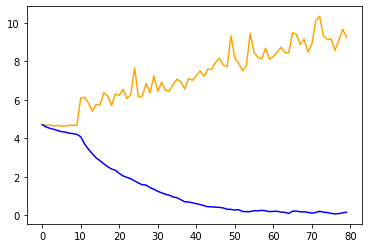

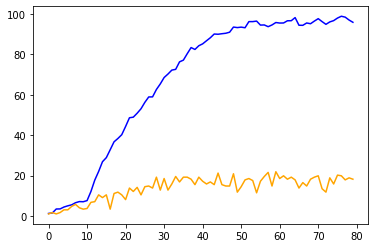

In [26]:
plt.plot(val_loss, color="orange")
plt.plot(train_loss, color="blue")
plt.show()
plt.plot(train_acc, color="blue")
plt.plot(val_acc, color="orange")
plt.show()
# train_acc
# val_acc

# 100 Labels with Random Crop RESNET50

In [27]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, mode='train', site=1, channels=[1,2,3,4,5,6], transform=None):
        self.records = df.to_records(index=False)
        self.channels = channels
        # self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.transform = transform
        self.unique_list = np.unique([int(n.split("_")[1]) for n in df['sirna']])
        self.mapping = {}
        for (i, val) in enumerate(self.unique_list):
            self.mapping[val] = i

    @staticmethod
    def _load_img_as_tensor(file_name):
        with Image.open(file_name) as img:
            return T.ToTensor()(img)

    def _get_img_path(self, index, channel, site):
        mode = self.mode
        if self.mode == 'valid':
            mode = 'train'
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,mode,experiment,f'Plate{plate}',f'{well}_s{site}_w{channel}.png'])

    def __getitem__(self, index):
        skip = False
        paths_1 = [self._get_img_path(index, ch, 1) for ch in self.channels]
        paths_2 = [self._get_img_path(index, ch, 2) for ch in self.channels]
        img_1 = []
        for img_path in paths_1:
            if Path(img_path).exists():
                # gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True)) # how to add guasian noise
                img_1.append(self._load_img_as_tensor(img_path))
            else:
                img_1.append(torch.zeros(1, 512, 512))
        img_1 = torch.cat(img_1)
        img_2 = []
        for img_path in paths_2:
            if Path(img_path).exists():
                img_2.append(self._load_img_as_tensor(img_path))
            else:
                img_2.append(torch.zeros(1, 512, 512))
        img_2 = torch.cat(img_2)
        img_1 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_1])
        img_2 = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths_2])
        img = torch.cat([img_1, img_2])
        if self.mode == 'train':
            # if training, then apply transformation
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split("_")[1])]
        elif self.mode == 'valid':
            if self.transform is not None:
                img = self.transform(img)
            return img, self.mapping[int(self.records[index].sirna.split('_')[1])]
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

transforms = T.Compose([
    T.RandomCrop(384, 384),
    T.RandomHorizontalFlip(),
    T.RandomRotation(90),
    T.RandomVerticalFlip()
])

In [28]:
df = pd.read_csv(path_data+'/train.csv')
df["label"] = -1
for index, obs in df.iterrows():
    df['label'].loc[index] = int(obs['sirna'].split("_")[1])
subset_index = df['label'] <= 100
subset_df = df.loc[subset_index, :]
subset_df = subset_df.drop(['label'], axis = 1)
df_train, df_test = train_test_split(subset_df, test_size = 0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

ds_train = ImagesDS(df_train, path_data, mode='train', transform=transforms)
ds_val = ImagesDS(df_val, path_data, mode='valid')
ds_test = ImagesDS(df_test, path_data, mode='valid')

train_loader = D.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False)
valid_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=False)

## Example model training

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is: {device}")

model = models.resnet50(pretrained=True)
classes = 100
model.fc = torch.nn.Linear(model.fc.in_features, classes)

trained_kernel = model.conv1.weight
new_conv = nn.Conv2d(12, 64, 7, 2, 3, bias=False)
with torch.no_grad():
    new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)] * 12, dim=1)
model.conv1 = new_conv
model = model.to(device)

Device is: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tomj/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [30]:
validation_accuracy(model, valid_loader, True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Accuracy of the network on the 330 test images: 0.9090909090909091


0.9090909090909091

## Learning with SGD

In [31]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [32]:
n_epochs = 25
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in trange(n_epochs, desc='Epochs', leave=False):
    if epoch == 0:
        for name, child in model.named_children():
            if name == 'fc':
                # print(f"{name} is unfrozen")
                for param in child.parameters():
                    param.requires_grad = True
            else:
                # print(f"{name} is frozen")
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 10:
        print("Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True
    running_loss = 0.0
    correct = 0
    total=0
    for batch_idx, (data_, target_) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        # if (batch_idx) % 50 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #            .format(epoch + 1, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'train-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}')
  
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet_100.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.6977, train-acc: 0.8982
validation loss: 4.6343, validation acc: 3.3670
Improvement-Detected, save-model


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7773, train-acc: 1.0105
validation loss: 4.7371, validation acc: 0.6734


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7723, train-acc: 0.8982
validation loss: 4.7487, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7625, train-acc: 0.8982
validation loss: 4.7620, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7535, train-acc: 1.6841
validation loss: 4.7794, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7412, train-acc: 1.5344
validation loss: 4.7875, validation acc: 1.6835


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7295, train-acc: 1.4970
validation loss: 4.7841, validation acc: 1.3468


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7210, train-acc: 1.8338
validation loss: 4.7880, validation acc: 1.0101


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7128, train-acc: 1.8338
validation loss: 4.7908, validation acc: 2.3569


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

train-loss: 4.7038, train-acc: 1.9087
validation loss: 4.7940, validation acc: 0.3367
Turn on all the layers


Batches:   0%|          | 0/167 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 4.00 GiB total capacity; 2.48 GiB already allocated; 140.80 KiB free; 2.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [33]:
validation_accuracy(model, valid_loader, True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 4.00 GiB total capacity; 2.48 GiB already allocated; 140.80 KiB free; 2.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

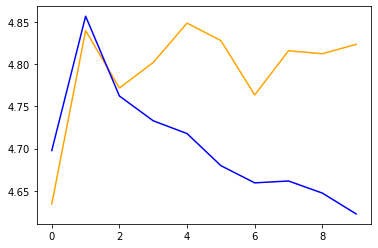

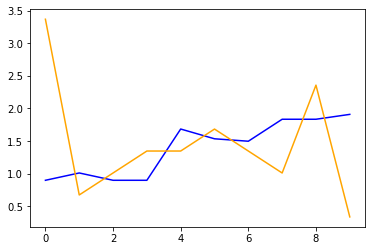

In [34]:
plt.plot(val_loss, color="orange")
plt.plot(train_loss, color="blue")
plt.show()
plt.plot(train_acc, color="blue")
plt.plot(val_acc, color="orange")
plt.show()
# train_acc
# val_acc

This is taking random crops of 384 by 384 images with both sites used. Only first 100 labels are used here.

## Learning with Adam and learning LR

In [11]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [12]:
# Nepochs = 1
# learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# for lr in learning_rates:
#     stop = False
#     # Nbatch = 100
#     model_s = model
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model_s.parameters(), lr=lr)
#     print(f"Initiating with Learning Rate: {lr}")
#     model_s.train()
#     for i in range(Nepochs):
#         if stop:
#             break
#         for j, batch in enumerate(train_loader):
#             images, labels = batch
#             images = images.to(device)
#             labels = labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             if (j) % 200 == 0:
#                 print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                        .format(i+1, Nepochs, j+1, len(train_loader), loss.item()))
#             # Nbatch -= 1
#             # if Nbatch <= 0:
#             #     stop = True
#             #     break
#         print("using lr: {} we achieved a loss of {:.4f}".format(lr, loss.item()))
#         print("\n")